#Импорт

In [1]:
!pip install razdel
!pip install pytorch_lightning

     |████████████████████████████████| 526 kB 5.0 MB/s 
     |████████████████████████████████| 396 kB 65.3 MB/s 
     |████████████████████████████████| 133 kB 78.1 MB/s 
     |████████████████████████████████| 829 kB 72.4 MB/s 
     |████████████████████████████████| 596 kB 63.1 MB/s 
     |████████████████████████████████| 1.1 MB 55.1 MB/s 
     |████████████████████████████████| 144 kB 66.4 MB/s 
     |████████████████████████████████| 160 kB 72.9 MB/s 
     |████████████████████████████████| 271 kB 76.3 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=3626f0cb105498d2ea3213c2d0d1a9181fd11e029a20dbdb81e846f07f4063a8
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found exis

In [2]:
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import pandas as pd

from razdel import tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE
from collections import defaultdict, Counter
import re
%matplotlib inline

In [3]:
COLAB = True

if COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  DATA='/content/drive/MyDrive/учебка/магистратура/3/ML'
else:
  DATA='data/data/archive'


Mounted at /content/drive


# Анализ данных

In [4]:
pos = pd.read_csv(f'{DATA}/positive.csv', 
                  sep=';', 
                  header=None, 
                  usecols=[3], 
                  names=['text']) #names=['id', 'id2', 'nick', 'text', 'meta1', 'meta2', 'meta3', 'meta4', 'meta5', 'meta6', 'meta7', 'meta8'] )
pos['label'] = 1

In [5]:
neg = pd.read_csv(f'{DATA}/negative.csv', sep=';', header=None, usecols=[3], names=['text']) 
neg['label'] = 0

In [6]:
full_ds = pd.concat((pos, neg))
full_ds['tokenized'] = full_ds.apply(lambda row: [t.text for t in tokenize(row['text'])], axis=1)

In [7]:
train_ds, test_ds = train_test_split(full_ds, test_size=0.2)

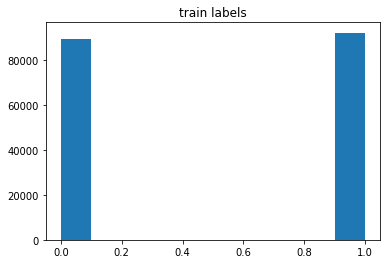

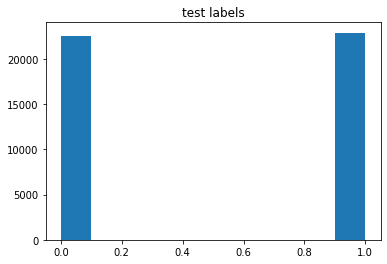

In [8]:
plt.hist(train_ds['label'])
plt.title('train labels')
plt.show()
plt.hist(test_ds['label'])
plt.title('test labels')
plt.show()

Обучение классификатора на таких данных дает accuracy=100%. Происходит это из-за наличия скобок "(" и ")". Особенность базы в том, что скобки напрямую выражают эмоции коментария. Если есть ")", то коментарий positive, если "(" - negative. Ниже отрисованны 200 случайных примеров из тест сета. По оси X - количество "(" в тексте. По оси Y - количество ")".


Для дальнейших экспериментов удалим все не чисто русские токены

In [9]:
rus_word = re.compile('^[а-яё\-]+$')
def remove_non_rus(splited_line):
    return [w for w in map(str.lower, splited_line) if rus_word.match(w)]

# print(remove_non_rus('Я есть грут @'.split()))
# print(remove_non_rus('Я есть грут @'.split()))
# print(remove_non_rus('Я eat грут @'.split()))
# print(remove_non_rus('Я есть грут, ё-ёё'.split()))
# print(remove_non_rus('Я есть )))) грут '.split()))

In [76]:
count_vec = CountVectorizer(tokenizer=remove_non_rus, lowercase=False, token_pattern=None, max_features=100)
train_counts = count_vec.fit_transform(train_ds['tokenized'])
test_counts = count_vec.transform(test_ds['tokenized'])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


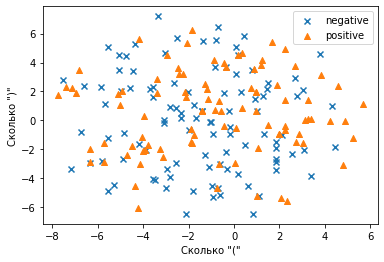

In [77]:
# t-SNE plot
def plot(embs, labels):
    embeddings = TSNE(n_components=2)
    Y = embeddings.fit_transform(embs)
    #Y = embs.toarray()
    y_0 = Y[labels==0]
    y_1 = Y[labels==1]
    plt.scatter(y_0[:, 0], y_0[:, 1], marker='x', cmap=plt.cm.Spectral)
    plt.scatter(y_1[:, 0], y_1[:, 1], marker='^', cmap=plt.cm.Spectral)
    plt.xlabel('Сколько "("')
    plt.ylabel('Сколько ")"')
    plt.legend(['negative', 'positive'])
    plt.show()
plot(test_counts[:200], test_ds['label'][:200])

# Классические модели

In [78]:
#from sklearn.naive_bayes import MultinomialNB
nb_counts = MultinomialNB() 
nb_counts.fit(train_counts, train_ds['label'])
#knn_counts.fit(test_counts, test_ds['label'])
# KNeighborsClassifier(n_neighbors=2)
#nb_tfidf.fit(train_tfidf, train_ds['label'])


MultinomialNB()

In [79]:
print(sklearn.metrics.classification_report(test_ds['label'], nb_counts.predict(test_counts), target_names=['negative', 'positive']))


              precision    recall  f1-score   support

    negative       0.63      0.56      0.60     22493
    positive       0.61      0.68      0.64     22874

    accuracy                           0.62     45367
   macro avg       0.62      0.62      0.62     45367
weighted avg       0.62      0.62      0.62     45367



In [63]:
tfidf = TfidfVectorizer(tokenizer=lambda x:x, lowercase=False, max_features=200)
train_tfidf = tfidf.fit_transform(train_ds['tokenized'])
test_tfidf = tfidf.transform(test_ds['tokenized'])


In [64]:
nb_tfidf = MultinomialNB() # KNeighborsClassifier(n_neighbors=2)
nb_tfidf.fit(train_tfidf, train_ds['label'])

MultinomialNB()

In [65]:
print(sklearn.metrics.classification_report(test_ds['label'], nb_tfidf.predict(test_tfidf), target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.99      0.96      0.97     22493
    positive       0.96      0.99      0.98     22874

    accuracy                           0.98     45367
   macro avg       0.98      0.98      0.98     45367
weighted avg       0.98      0.98      0.98     45367



# Нейросети

In [66]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
import pytorch_lightning as pl
import torchmetrics
import pandas as pd

In [91]:

class LitBase(pl.LightningModule):
  #Шаблон для моделей
    def __init__(self, lr=1e-4, wd=1e-6, 
                 scheduler=torch.optim.lr_scheduler.ExponentialLR, 
                 scheduler_kwargs={'gamma': 0.95}):
        super().__init__()
        self.lr = lr
        self.wd = wd
        self.model = None
        self.criterion = nn.BCEWithLogitsLoss()
        self.scheduler = scheduler
        self.scheduler_kwargs = scheduler_kwargs
    
    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            if isinstance(x, list) and len(x) == 2 :
                x = x[0]
            else:
                print(f'{len(x)} {x[0].shape} {x[1].shape}')
                raise RuntimeError()
        return self.model(x)
    
    def compute_loss(self, batch, batch_idx):
        #print(batch)
        x, y = batch
        #print(f'{x.shape=} {y.shape=}')
        btz = x.shape[0]
        logits = self(x)
        #print(f'{logits.shape=}')
        loss = self.criterion(logits.view(btz, -1), y.view(btz, -1))
        return loss, logits
    
    def training_step(self, batch, batch_idx):
        # Logging to TensorBoard by default
        loss, logits = self.compute_loss(batch, batch_idx)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, logits = self.compute_loss(batch, batch_idx)
        self.log("val_loss", loss,  prog_bar=True)
        predicted = (logits.view(-1)>0.5).float()
        y = batch[1].view(-1)
        acc = (y == predicted).sum()/y.shape[0]
        self.log("val_acc", acc,  prog_bar=True)
        return loss
    
    def predicts_step(self, batch, batch_idx):
        x = batch[0]
        return self(x)

    def get_params(self):
      return {'weight_decay': self.wd,
              'learning_rate': self.lr, 
              'lr_scheduler': self.scheduler, 
              'lr_scheduler_kwargs': self.scheduler_kwargs}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.wd)
        lr_scheduler = lr_scheduler_config = {           
            "scheduler": self.scheduler(optimizer, **self.scheduler_kwargs),
            "interval": "epoch"}
        return {'optimizer': optimizer,
                'lr_scheduler': lr_scheduler}

In [133]:
class LitDNN(LitBase):
    def __init__(self, 
                 num_features, 
                 num_layers=2, 
                 dim=512, 
                 dropout_p=0,  
                 batchnorm=False,
                 init_func=lambda x: x,
                 **kwargs):
        super().__init__(**kwargs)
        self.num_features = num_features
        self.num_layers = num_layers
        self.dim = dim
        self.dropout_p = dropout_p
        model = []
        for i in range(num_layers): 
            model.append(nn.Linear(num_features if i == 0 else dim, 
                                   1 if i == num_layers - 1 else dim))
            if i < num_layers - 1:
                if batchnorm:
                    model.append(torch.nn.BatchNorm1d(dim))
                model.append(nn.ReLU())
                if dropout_p>0:
                    model.append(nn.Dropout(dropout_p))
        self.model = nn.Sequential(*model)

        for params in self.model.parameters():
            if len(params.shape) > 1:
                init_func(params.data)
      
    def get_params(self):
      out = super().get_params()
      out['num_features'] = self.num_features
      out['num_layers'] = self.num_layers
      out['dim'] = self.dim
      out['dropout_p'] = self.dropout_p
      return out
  


In [129]:
train_torch_ds = TensorDataset(torch.from_numpy(train_tfidf.toarray()).float(), 
                               torch.from_numpy(train_ds['label'].values).float())

test_torch_ds = TensorDataset(torch.from_numpy(test_tfidf.toarray()).float(), 
                               torch.from_numpy(test_ds['label'].values).float())

# train_torch_ds = TensorDataset(torch.from_numpy(train_counts.toarray()).float(), 
#                                torch.from_numpy(train_ds['label'].values).float())

# test_torch_ds = TensorDataset(torch.from_numpy(test_counts.toarray()).float(), 
#                                torch.from_numpy(test_ds['label'].values).float())

In [130]:
def cls_report(model, dl):
    predict = []
    labels = []
    with torch.no_grad():
        for x, y in dl:
            p = (model(x) > 0).cpu().int()
            predict.append(p.numpy())
            labels.append(y.numpy())
    predict = np.concatenate(predict)
    labels = np.concatenate(labels)

    report = sklearn.metrics.classification_report(labels, 
                                                predict, 
                                                target_names=['negative', 'positive'])
    cf = sklearn.metrics.confusion_matrix(labels, predict)
    return report, cf

In [131]:
#EXPS = []
def print_exp(exp):
  for k,v in exp.items():
    print(f'{k}: {v}')

def RUN_EXP(model, batch_size=128, epochs=10):
  train_dl = DataLoader(train_torch_ds, batch_size=batch_size, shuffle=True, num_workers=2)
  test_dl = DataLoader(test_torch_ds, batch_size=batch_size, shuffle=False, num_workers=0)
  exp = model.get_params()
  exp['batch_size'] = batch_size
  exp['epochs'] = epochs
  print(f"Params {pd.Series(exp)}")
  trainer = pl.Trainer(gpus=1, 
                     auto_lr_find=False, 
                     max_epochs=epochs, 
                     log_every_n_steps=300, 
                     default_root_dir="models/dnn")
  
  trainer.fit(model, train_dl, test_dl)
  report = trainer.validate(model, test_dl)
  for k,v in report[0].items():
    exp[k] = v
  exp['val_report'], exp['val_cm'] = cls_report(model, test_dl)
  print_exp(exp)
  EXPS.append(exp)


## Exponential scheduler

In [102]:
dnn = LitDNN(200, num_layers=4, scheduler_kwargs={'gamma':1})
RUN_EXP(dnn, epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | model     | Sequential        | 628 K 
------------------------------------------------
628 K     Trainable params
0         Non-trainable params
628 K     Total params
2.515     Total estimated model params size (MB)


Params weight_decay                                                      1e-06
learning_rate                                                    0.0001
lr_scheduler           <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs                                        {'gamma': 1}
num_features                                                        200
num_layers                                                            4
dim                                                                 512
batch_size                                                          128
epochs                                                               10
dtype: object


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9861132502555847, 'val_loss': 0.04257733374834061}
--------------------------------------------------------------------------------
weight_decay: 1e-06
learning_rate: 0.0001
lr_scheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs: {'gamma': 1}
num_features: 200
num_layers: 4
dim: 512
batch_size: 128
epochs: 10
val_loss: 0.04257733374834061
val_acc: 0.9861132502555847
val_report:               precision    recall  f1-score   support

    negative       0.99      0.98      0.98     22493
    positive       0.98      0.99      0.99     22874

    accuracy                           0.99     45367
   macro avg       0.99      0.99      0.99     45367
weighted avg       0.99      0.99      0.99     45367

val_cm: [[22045   448]
 [  227 22647]]


In [103]:
dnn = LitDNN(200, num_layers=4, scheduler_kwargs={'gamma':0.95})
RUN_EXP(dnn, epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | model     | Sequential        | 628 K 
------------------------------------------------
628 K     Trainable params
0         Non-trainable params
628 K     Total params
2.515     Total estimated model params size (MB)


Params weight_decay                                                      1e-06
learning_rate                                                    0.0001
lr_scheduler           <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs                                     {'gamma': 0.95}
num_features                                                        200
num_layers                                                            4
dim                                                                 512
batch_size                                                          128
epochs                                                               10
dtype: object


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9859589338302612, 'val_loss': 0.03911896422505379}
--------------------------------------------------------------------------------
weight_decay: 1e-06
learning_rate: 0.0001
lr_scheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs: {'gamma': 0.95}
num_features: 200
num_layers: 4
dim: 512
batch_size: 128
epochs: 10
val_loss: 0.03911896422505379
val_acc: 0.9859589338302612
val_report:               precision    recall  f1-score   support

    negative       0.98      0.99      0.99     22493
    positive       0.99      0.98      0.99     22874

    accuracy                           0.99     45367
   macro avg       0.99      0.99      0.99     45367
weighted avg       0.99      0.99      0.99     45367

val_cm: [[22282   211]
 [  420 22454]]


## Schedulers



In [121]:
dnn = LitDNN(200, num_layers=4, lr=1e-2, scheduler=torch.optim.lr_scheduler.MultiStepLR, scheduler_kwargs={'gamma':0.1, 'milestones':[2, 4, 9]})
RUN_EXP(dnn, epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | model     | Sequential        | 628 K 
------------------------------------------------
628 K     Trainable params
0         Non-trainable params
628 K     Total params
2.515     Total estimated model params size (MB)


Params weight_decay                                                    1e-06
learning_rate                                                    0.01
lr_scheduler           <class 'torch.optim.lr_scheduler.MultiStepLR'>
lr_scheduler_kwargs           {'gamma': 0.1, 'milestones': [2, 4, 9]}
num_features                                                      200
num_layers                                                          4
dim                                                               512
dropout_p                                                           0
batch_size                                                        128
epochs                                                             10
dtype: object


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9870390295982361, 'val_loss': 0.03255350887775421}
--------------------------------------------------------------------------------
weight_decay: 1e-06
learning_rate: 0.01
lr_scheduler: <class 'torch.optim.lr_scheduler.MultiStepLR'>
lr_scheduler_kwargs: {'gamma': 0.1, 'milestones': [2, 4, 9]}
num_features: 200
num_layers: 4
dim: 512
dropout_p: 0
batch_size: 128
epochs: 10
val_loss: 0.03255350887775421
val_acc: 0.9870390295982361
val_report:               precision    recall  f1-score   support

    negative       0.99      0.99      0.99     22493
    positive       0.99      0.99      0.99     22874

    accuracy                           0.99     45367
   macro avg       0.99      0.99      0.99     45367
weighted avg       0.99      0.99      0.99     45367

val_cm: [[22232   261]
 [  321 22553]]


In [122]:
dnn = LitDNN(200, num_layers=4, lr=1e-2, scheduler=torch.optim.lr_scheduler.OneCycleLR, scheduler_kwargs={'max_lr':1e-2, 'epochs':10, 'steps_per_epoch': 1773})
RUN_EXP(dnn, epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/optimizers.py:176: RuntimeWarning: A `OneCycleLR` scheduler is using 'interval': 'epoch'. Are you sure you didn't mean 'interval': 'step'?
  RuntimeWarning,

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | model     | Sequential        | 628 K 
------------------------------------------------
628 K     Trainable params
0         Non-trainable params
628 K     Total params
2.515     Total estimated model params size (MB)


Params weight_decay                                                       1e-06
learning_rate                                                       0.01
lr_scheduler               <class 'torch.optim.lr_scheduler.OneCycleLR'>
lr_scheduler_kwargs    {'max_lr': 0.01, 'epochs': 10, 'steps_per_epoc...
num_features                                                         200
num_layers                                                             4
dim                                                                  512
dropout_p                                                              0
batch_size                                                           128
epochs                                                                10
dtype: object


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9859809875488281, 'val_loss': 0.06052244454622269}
--------------------------------------------------------------------------------
weight_decay: 1e-06
learning_rate: 0.01
lr_scheduler: <class 'torch.optim.lr_scheduler.OneCycleLR'>
lr_scheduler_kwargs: {'max_lr': 0.01, 'epochs': 10, 'steps_per_epoch': 1773}
num_features: 200
num_layers: 4
dim: 512
dropout_p: 0
batch_size: 128
epochs: 10
val_loss: 0.06052244454622269
val_acc: 0.9859809875488281
val_report:               precision    recall  f1-score   support

    negative       0.99      0.99      0.99     22493
    positive       0.99      0.99      0.99     22874

    accuracy                           0.99     45367
   macro avg       0.99      0.99      0.99     45367
weighted avg       0.99      0.99      0.99     45367

val_cm: [[22165   328]
 [  315 22559]]


In [123]:
dnn = LitDNN(200, num_layers=4, lr=1e-2, scheduler=torch.optim.lr_scheduler.CosineAnnealingLR, scheduler_kwargs={'T_max':10, 'eta_min':0})
RUN_EXP(dnn, epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | model     | Sequential        | 628 K 
------------------------------------------------
628 K     Trainable params
0         Non-trainable params
628 K     Total params
2.515     Total estimated model params size (MB)


Params weight_decay                                                       1e-06
learning_rate                                                       0.01
lr_scheduler           <class 'torch.optim.lr_scheduler.CosineAnneali...
lr_scheduler_kwargs                          {'T_max': 10, 'eta_min': 0}
num_features                                                         200
num_layers                                                             4
dim                                                                  512
dropout_p                                                              0
batch_size                                                           128
epochs                                                                10
dtype: object


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9866202473640442, 'val_loss': 0.06908383965492249}
--------------------------------------------------------------------------------
weight_decay: 1e-06
learning_rate: 0.01
lr_scheduler: <class 'torch.optim.lr_scheduler.CosineAnnealingLR'>
lr_scheduler_kwargs: {'T_max': 10, 'eta_min': 0}
num_features: 200
num_layers: 4
dim: 512
dropout_p: 0
batch_size: 128
epochs: 10
val_loss: 0.06908383965492249
val_acc: 0.9866202473640442
val_report:               precision    recall  f1-score   support

    negative       0.98      0.99      0.99     22493
    positive       0.99      0.98      0.99     22874

    accuracy                           0.99     45367
   macro avg       0.99      0.99      0.99     45367
weighted avg       0.99      0.99      0.99     45367

val_cm: [[22253   240]
 [  357 22517]]


##weight decay

In [139]:
dnn = LitDNN(200, num_layers=4, wd=1e-2, scheduler_kwargs={'gamma':0.95})
RUN_EXP(dnn, epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | model     | Sequential        | 628 K 
------------------------------------------------
628 K     Trainable params
0         Non-trainable params
628 K     Total params
2.515     Total estimated model params size (MB)


Params weight_decay                                                       0.01
learning_rate                                                    0.0001
lr_scheduler           <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs                                     {'gamma': 0.95}
num_features                                                        200
num_layers                                                            4
dim                                                                 512
dropout_p                                                             0
batch_size                                                          128
epochs                                                               10
dtype: object


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9843057990074158, 'val_loss': 0.05731487274169922}
--------------------------------------------------------------------------------
weight_decay: 0.01
learning_rate: 0.0001
lr_scheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs: {'gamma': 0.95}
num_features: 200
num_layers: 4
dim: 512
dropout_p: 0
batch_size: 128
epochs: 10
val_loss: 0.05731487274169922
val_acc: 0.9843057990074158
val_report:               precision    recall  f1-score   support

    negative       0.99      0.98      0.98     22493
    positive       0.98      0.99      0.98     22874

    accuracy                           0.98     45367
   macro avg       0.98      0.98      0.98     45367
weighted avg       0.98      0.98      0.98     45367

val_cm: [[22043   450]
 [  263 22611]]


In [140]:
dnn = LitDNN(200, num_layers=4, wd=1e-3, scheduler_kwargs={'gamma':0.95})
RUN_EXP(dnn, epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | model     | Sequential        | 628 K 
------------------------------------------------
628 K     Trainable params
0         Non-trainable params
628 K     Total params
2.515     Total estimated model params size (MB)


Params weight_decay                                                      0.001
learning_rate                                                    0.0001
lr_scheduler           <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs                                     {'gamma': 0.95}
num_features                                                        200
num_layers                                                            4
dim                                                                 512
dropout_p                                                             0
batch_size                                                          128
epochs                                                               10
dtype: object


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9842396378517151, 'val_loss': 0.03228437900543213}
--------------------------------------------------------------------------------
weight_decay: 0.001
learning_rate: 0.0001
lr_scheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs: {'gamma': 0.95}
num_features: 200
num_layers: 4
dim: 512
dropout_p: 0
batch_size: 128
epochs: 10
val_loss: 0.03228437900543213
val_acc: 0.9842396378517151
val_report:               precision    recall  f1-score   support

    negative       0.98      0.99      0.99     22493
    positive       0.99      0.98      0.99     22874

    accuracy                           0.99     45367
   macro avg       0.99      0.99      0.99     45367
weighted avg       0.99      0.99      0.99     45367

val_cm: [[22309   184]
 [  472 22402]]


In [106]:
dnn = LitDNN(200, num_layers=4, wd=1e-4, scheduler_kwargs={'gamma':0.95})
RUN_EXP(dnn, epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | model     | Sequential        | 628 K 
------------------------------------------------
628 K     Trainable params
0         Non-trainable params
628 K     Total params
2.515     Total estimated model params size (MB)


Params weight_decay                                                     0.0001
learning_rate                                                    0.0001
lr_scheduler           <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs                                     {'gamma': 0.95}
num_features                                                        200
num_layers                                                            4
dim                                                                 512
dropout_p                                                             0
batch_size                                                          128
epochs                                                               10
dtype: object


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9865540862083435, 'val_loss': 0.030107537284493446}
--------------------------------------------------------------------------------
weight_decay: 0.0001
learning_rate: 0.0001
lr_scheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs: {'gamma': 0.95}
num_features: 200
num_layers: 4
dim: 512
dropout_p: 0
batch_size: 128
epochs: 10
val_loss: 0.030107537284493446
val_acc: 0.9865540862083435
val_report:               precision    recall  f1-score   support

    negative       0.98      0.99      0.99     22493
    positive       0.99      0.98      0.99     22874

    accuracy                           0.99     45367
   macro avg       0.99      0.99      0.99     45367
weighted avg       0.99      0.99      0.99     45367

val_cm: [[22246   247]
 [  348 22526]]


In [107]:
dnn = LitDNN(200, num_layers=4, wd=1e-5, scheduler_kwargs={'gamma':0.95})
RUN_EXP(dnn, epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | model     | Sequential        | 628 K 
------------------------------------------------
628 K     Trainable params
0         Non-trainable params
628 K     Total params
2.515     Total estimated model params size (MB)


Params weight_decay                                                      1e-05
learning_rate                                                    0.0001
lr_scheduler           <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs                                     {'gamma': 0.95}
num_features                                                        200
num_layers                                                            4
dim                                                                 512
dropout_p                                                             0
batch_size                                                          128
epochs                                                               10
dtype: object


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9861353039741516, 'val_loss': 0.03654109314084053}
--------------------------------------------------------------------------------
weight_decay: 1e-05
learning_rate: 0.0001
lr_scheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs: {'gamma': 0.95}
num_features: 200
num_layers: 4
dim: 512
dropout_p: 0
batch_size: 128
epochs: 10
val_loss: 0.03654109314084053
val_acc: 0.9861353039741516
val_report:               precision    recall  f1-score   support

    negative       0.99      0.99      0.99     22493
    positive       0.99      0.99      0.99     22874

    accuracy                           0.99     45367
   macro avg       0.99      0.99      0.99     45367
weighted avg       0.99      0.99      0.99     45367

val_cm: [[22160   333]
 [  286 22588]]


In [108]:
dnn = LitDNN(200, num_layers=4, wd=1e-7, scheduler_kwargs={'gamma':0.95})
RUN_EXP(dnn, epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | model     | Sequential        | 628 K 
------------------------------------------------
628 K     Trainable params
0         Non-trainable params
628 K     Total params
2.515     Total estimated model params size (MB)


Params weight_decay                                                      1e-07
learning_rate                                                    0.0001
lr_scheduler           <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs                                     {'gamma': 0.95}
num_features                                                        200
num_layers                                                            4
dim                                                                 512
dropout_p                                                             0
batch_size                                                          128
epochs                                                               10
dtype: object


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9855622053146362, 'val_loss': 0.0394638292491436}
--------------------------------------------------------------------------------
weight_decay: 1e-07
learning_rate: 0.0001
lr_scheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs: {'gamma': 0.95}
num_features: 200
num_layers: 4
dim: 512
dropout_p: 0
batch_size: 128
epochs: 10
val_loss: 0.0394638292491436
val_acc: 0.9855622053146362
val_report:               precision    recall  f1-score   support

    negative       0.99      0.99      0.99     22493
    positive       0.99      0.99      0.99     22874

    accuracy                           0.99     45367
   macro avg       0.99      0.99      0.99     45367
weighted avg       0.99      0.99      0.99     45367

val_cm: [[22169   324]
 [  329 22545]]


## Dropout

In [109]:
dnn = LitDNN(200, num_layers=4, dropout_p=0.1, scheduler_kwargs={'gamma':0.95})
RUN_EXP(dnn, epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | model     | Sequential        | 628 K 
------------------------------------------------
628 K     Trainable params
0         Non-trainable params
628 K     Total params
2.515     Total estimated model params size (MB)


Params weight_decay                                                      1e-06
learning_rate                                                    0.0001
lr_scheduler           <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs                                     {'gamma': 0.95}
num_features                                                        200
num_layers                                                            4
dim                                                                 512
dropout_p                                                           0.1
batch_size                                                          128
epochs                                                               10
dtype: object


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9857164621353149, 'val_loss': 0.03224528208374977}
--------------------------------------------------------------------------------
weight_decay: 1e-06
learning_rate: 0.0001
lr_scheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs: {'gamma': 0.95}
num_features: 200
num_layers: 4
dim: 512
dropout_p: 0.1
batch_size: 128
epochs: 10
val_loss: 0.03224528208374977
val_acc: 0.9857164621353149
val_report:               precision    recall  f1-score   support

    negative       0.98      0.99      0.99     22493
    positive       0.99      0.98      0.99     22874

    accuracy                           0.99     45367
   macro avg       0.99      0.99      0.99     45367
weighted avg       0.99      0.99      0.99     45367

val_cm: [[22191   302]
 [  350 22524]]


In [110]:
dnn = LitDNN(200, num_layers=4, dropout_p=0.2, scheduler_kwargs={'gamma':0.95})
RUN_EXP(dnn, epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | model     | Sequential        | 628 K 
------------------------------------------------
628 K     Trainable params
0         Non-trainable params
628 K     Total params
2.515     Total estimated model params size (MB)


Params weight_decay                                                      1e-06
learning_rate                                                    0.0001
lr_scheduler           <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs                                     {'gamma': 0.95}
num_features                                                        200
num_layers                                                            4
dim                                                                 512
dropout_p                                                           0.2
batch_size                                                          128
epochs                                                               10
dtype: object


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9862675666809082, 'val_loss': 0.030669013038277626}
--------------------------------------------------------------------------------
weight_decay: 1e-06
learning_rate: 0.0001
lr_scheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs: {'gamma': 0.95}
num_features: 200
num_layers: 4
dim: 512
dropout_p: 0.2
batch_size: 128
epochs: 10
val_loss: 0.030669013038277626
val_acc: 0.9862675666809082
val_report:               precision    recall  f1-score   support

    negative       0.99      0.98      0.99     22493
    positive       0.98      0.99      0.99     22874

    accuracy                           0.99     45367
   macro avg       0.99      0.99      0.99     45367
weighted avg       0.99      0.99      0.99     45367

val_cm: [[22137   356]
 [  317 22557]]


In [111]:
dnn = LitDNN(200, num_layers=4, dropout_p=0.3, scheduler_kwargs={'gamma':0.95})
RUN_EXP(dnn, epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | model     | Sequential        | 628 K 
------------------------------------------------
628 K     Trainable params
0         Non-trainable params
628 K     Total params
2.515     Total estimated model params size (MB)


Params weight_decay                                                      1e-06
learning_rate                                                    0.0001
lr_scheduler           <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs                                     {'gamma': 0.95}
num_features                                                        200
num_layers                                                            4
dim                                                                 512
dropout_p                                                           0.3
batch_size                                                          128
epochs                                                               10
dtype: object


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9867745041847229, 'val_loss': 0.028154872357845306}
--------------------------------------------------------------------------------
weight_decay: 1e-06
learning_rate: 0.0001
lr_scheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs: {'gamma': 0.95}
num_features: 200
num_layers: 4
dim: 512
dropout_p: 0.3
batch_size: 128
epochs: 10
val_loss: 0.028154872357845306
val_acc: 0.9867745041847229
val_report:               precision    recall  f1-score   support

    negative       0.98      0.99      0.99     22493
    positive       0.99      0.99      0.99     22874

    accuracy                           0.99     45367
   macro avg       0.99      0.99      0.99     45367
weighted avg       0.99      0.99      0.99     45367

val_cm: [[22184   309]
 [  339 22535]]


In [112]:
dnn = LitDNN(200, num_layers=4, dropout_p=0.4, scheduler_kwargs={'gamma':0.95})
RUN_EXP(dnn, epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | model     | Sequential        | 628 K 
------------------------------------------------
628 K     Trainable params
0         Non-trainable params
628 K     Total params
2.515     Total estimated model params size (MB)


Params weight_decay                                                      1e-06
learning_rate                                                    0.0001
lr_scheduler           <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs                                     {'gamma': 0.95}
num_features                                                        200
num_layers                                                            4
dim                                                                 512
dropout_p                                                           0.4
batch_size                                                          128
epochs                                                               10
dtype: object


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9867525100708008, 'val_loss': 0.028522860258817673}
--------------------------------------------------------------------------------
weight_decay: 1e-06
learning_rate: 0.0001
lr_scheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs: {'gamma': 0.95}
num_features: 200
num_layers: 4
dim: 512
dropout_p: 0.4
batch_size: 128
epochs: 10
val_loss: 0.028522860258817673
val_acc: 0.9867525100708008
val_report:               precision    recall  f1-score   support

    negative       0.99      0.99      0.99     22493
    positive       0.99      0.99      0.99     22874

    accuracy                           0.99     45367
   macro avg       0.99      0.99      0.99     45367
weighted avg       0.99      0.99      0.99     45367

val_cm: [[22157   336]
 [  325 22549]]


In [113]:
dnn = LitDNN(200, num_layers=4, dropout_p=0.5, scheduler_kwargs={'gamma':0.95})
RUN_EXP(dnn, epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | model     | Sequential        | 628 K 
------------------------------------------------
628 K     Trainable params
0         Non-trainable params
628 K     Total params
2.515     Total estimated model params size (MB)


Params weight_decay                                                      1e-06
learning_rate                                                    0.0001
lr_scheduler           <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs                                     {'gamma': 0.95}
num_features                                                        200
num_layers                                                            4
dim                                                                 512
dropout_p                                                           0.5
batch_size                                                          128
epochs                                                               10
dtype: object


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9861793518066406, 'val_loss': 0.02786211296916008}
--------------------------------------------------------------------------------
weight_decay: 1e-06
learning_rate: 0.0001
lr_scheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs: {'gamma': 0.95}
num_features: 200
num_layers: 4
dim: 512
dropout_p: 0.5
batch_size: 128
epochs: 10
val_loss: 0.02786211296916008
val_acc: 0.9861793518066406
val_report:               precision    recall  f1-score   support

    negative       0.98      0.99      0.99     22493
    positive       0.99      0.98      0.99     22874

    accuracy                           0.99     45367
   macro avg       0.99      0.99      0.99     45367
weighted avg       0.99      0.99      0.99     45367

val_cm: [[22224   269]
 [  370 22504]]


In [115]:
dnn = LitDNN(200, num_layers=4, dropout_p=0.6, scheduler_kwargs={'gamma':0.95})
RUN_EXP(dnn, epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | model     | Sequential        | 628 K 
------------------------------------------------
628 K     Trainable params
0         Non-trainable params
628 K     Total params
2.515     Total estimated model params size (MB)


Params weight_decay                                                      1e-06
learning_rate                                                    0.0001
lr_scheduler           <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs                                     {'gamma': 0.95}
num_features                                                        200
num_layers                                                            4
dim                                                                 512
dropout_p                                                           0.6
batch_size                                                          128
epochs                                                               10
dtype: object


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9861793518066406, 'val_loss': 0.028235701844096184}
--------------------------------------------------------------------------------
weight_decay: 1e-06
learning_rate: 0.0001
lr_scheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs: {'gamma': 0.95}
num_features: 200
num_layers: 4
dim: 512
dropout_p: 0.6
batch_size: 128
epochs: 10
val_loss: 0.028235701844096184
val_acc: 0.9861793518066406
val_report:               precision    recall  f1-score   support

    negative       0.98      0.99      0.98     22493
    positive       0.99      0.98      0.98     22874

    accuracy                           0.98     45367
   macro avg       0.98      0.98      0.98     45367
weighted avg       0.98      0.98      0.98     45367

val_cm: [[22177   316]
 [  370 22504]]


## BatchNorm

In [120]:
dnn = LitDNN(200, num_layers=4, batchnorm=True, scheduler_kwargs={'gamma':0.95})
RUN_EXP(dnn, epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | model     | Sequential        | 631 K 
------------------------------------------------
631 K     Trainable params
0         Non-trainable params
631 K     Total params
2.527     Total estimated model params size (MB)


Params weight_decay                                                      1e-06
learning_rate                                                    0.0001
lr_scheduler           <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs                                     {'gamma': 0.95}
num_features                                                        200
num_layers                                                            4
dim                                                                 512
dropout_p                                                             0
batch_size                                                          128
epochs                                                               10
dtype: object


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9860250949859619, 'val_loss': 0.04850801080465317}
--------------------------------------------------------------------------------
weight_decay: 1e-06
learning_rate: 0.0001
lr_scheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs: {'gamma': 0.95}
num_features: 200
num_layers: 4
dim: 512
dropout_p: 0
batch_size: 128
epochs: 10
val_loss: 0.04850801080465317
val_acc: 0.9860250949859619
val_report:               precision    recall  f1-score   support

    negative       0.98      0.99      0.99     22493
    positive       0.99      0.98      0.99     22874

    accuracy                           0.99     45367
   macro avg       0.99      0.99      0.99     45367
weighted avg       0.99      0.99      0.99     45367

val_cm: [[22194   299]
 [  375 22499]]


## Initialization

In [134]:
dnn = LitDNN(200, num_layers=4, init_func=lambda x: torch.nn.init.xavier_uniform_(x, torch.nn.init.calculate_gain('relu')), scheduler_kwargs={'gamma':0.95})
RUN_EXP(dnn, epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | model     | Sequential        | 628 K 
------------------------------------------------
628 K     Trainable params
0         Non-trainable params
628 K     Total params
2.515     Total estimated model params size (MB)


Params weight_decay                                                      1e-06
learning_rate                                                    0.0001
lr_scheduler           <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs                                     {'gamma': 0.95}
num_features                                                        200
num_layers                                                            4
dim                                                                 512
dropout_p                                                             0
batch_size                                                          128
epochs                                                               10
dtype: object


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9853197336196899, 'val_loss': 0.042935509234666824}
--------------------------------------------------------------------------------
weight_decay: 1e-06
learning_rate: 0.0001
lr_scheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs: {'gamma': 0.95}
num_features: 200
num_layers: 4
dim: 512
dropout_p: 0
batch_size: 128
epochs: 10
val_loss: 0.042935509234666824
val_acc: 0.9853197336196899
val_report:               precision    recall  f1-score   support

    negative       0.98      0.99      0.99     22493
    positive       0.99      0.98      0.99     22874

    accuracy                           0.99     45367
   macro avg       0.99      0.99      0.99     45367
weighted avg       0.99      0.99      0.99     45367

val_cm: [[22305   188]
 [  477 22397]]


In [135]:
dnn = LitDNN(200, num_layers=4, init_func=lambda x: torch.nn.init.xavier_normal_(x, torch.nn.init.calculate_gain('relu')), scheduler_kwargs={'gamma':0.95})
RUN_EXP(dnn, epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | model     | Sequential        | 628 K 
------------------------------------------------
628 K     Trainable params
0         Non-trainable params
628 K     Total params
2.515     Total estimated model params size (MB)


Params weight_decay                                                      1e-06
learning_rate                                                    0.0001
lr_scheduler           <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs                                     {'gamma': 0.95}
num_features                                                        200
num_layers                                                            4
dim                                                                 512
dropout_p                                                             0
batch_size                                                          128
epochs                                                               10
dtype: object


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9859809875488281, 'val_loss': 0.04100010171532631}
--------------------------------------------------------------------------------
weight_decay: 1e-06
learning_rate: 0.0001
lr_scheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs: {'gamma': 0.95}
num_features: 200
num_layers: 4
dim: 512
dropout_p: 0
batch_size: 128
epochs: 10
val_loss: 0.04100010171532631
val_acc: 0.9859809875488281
val_report:               precision    recall  f1-score   support

    negative       0.99      0.98      0.99     22493
    positive       0.98      0.99      0.99     22874

    accuracy                           0.99     45367
   macro avg       0.99      0.99      0.99     45367
weighted avg       0.99      0.99      0.99     45367

val_cm: [[22101   392]
 [  272 22602]]


In [136]:
dnn = LitDNN(200, num_layers=4, init_func=lambda x: torch.nn.init.kaiming_uniform_(x, torch.nn.init.calculate_gain('relu')), scheduler_kwargs={'gamma':0.95})
RUN_EXP(dnn, epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | model     | Sequential        | 628 K 
------------------------------------------------
628 K     Trainable params
0         Non-trainable params
628 K     Total params
2.515     Total estimated model params size (MB)


Params weight_decay                                                      1e-06
learning_rate                                                    0.0001
lr_scheduler           <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs                                     {'gamma': 0.95}
num_features                                                        200
num_layers                                                            4
dim                                                                 512
dropout_p                                                             0
batch_size                                                          128
epochs                                                               10
dtype: object


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9849891066551208, 'val_loss': 0.03874402493238449}
--------------------------------------------------------------------------------
weight_decay: 1e-06
learning_rate: 0.0001
lr_scheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs: {'gamma': 0.95}
num_features: 200
num_layers: 4
dim: 512
dropout_p: 0
batch_size: 128
epochs: 10
val_loss: 0.03874402493238449
val_acc: 0.9849891066551208
val_report:               precision    recall  f1-score   support

    negative       0.98      0.99      0.99     22493
    positive       0.99      0.98      0.99     22874

    accuracy                           0.99     45367
   macro avg       0.99      0.99      0.99     45367
weighted avg       0.99      0.99      0.99     45367

val_cm: [[22257   236]
 [  439 22435]]


In [137]:
dnn = LitDNN(200, num_layers=4, init_func=lambda x: torch.nn.init.kaiming_normal_(x, torch.nn.init.calculate_gain('relu')), scheduler_kwargs={'gamma':0.95})
RUN_EXP(dnn, epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | model     | Sequential        | 628 K 
------------------------------------------------
628 K     Trainable params
0         Non-trainable params
628 K     Total params
2.515     Total estimated model params size (MB)


Params weight_decay                                                      1e-06
learning_rate                                                    0.0001
lr_scheduler           <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs                                     {'gamma': 0.95}
num_features                                                        200
num_layers                                                            4
dim                                                                 512
dropout_p                                                             0
batch_size                                                          128
epochs                                                               10
dtype: object


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9851654171943665, 'val_loss': 0.038452036678791046}
--------------------------------------------------------------------------------
weight_decay: 1e-06
learning_rate: 0.0001
lr_scheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs: {'gamma': 0.95}
num_features: 200
num_layers: 4
dim: 512
dropout_p: 0
batch_size: 128
epochs: 10
val_loss: 0.038452036678791046
val_acc: 0.9851654171943665
val_report:               precision    recall  f1-score   support

    negative       0.98      0.99      0.99     22493
    positive       0.99      0.98      0.99     22874

    accuracy                           0.99     45367
   macro avg       0.99      0.99      0.99     45367
weighted avg       0.99      0.99      0.99     45367

val_cm: [[22259   234]
 [  420 22454]]


In [138]:
dnn = LitDNN(200, num_layers=4, init_func=lambda x: torch.nn.init.orthogonal_(x, torch.nn.init.calculate_gain('relu')), scheduler_kwargs={'gamma':0.95})
RUN_EXP(dnn, epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | model     | Sequential        | 628 K 
------------------------------------------------
628 K     Trainable params
0         Non-trainable params
628 K     Total params
2.515     Total estimated model params size (MB)


Params weight_decay                                                      1e-06
learning_rate                                                    0.0001
lr_scheduler           <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs                                     {'gamma': 0.95}
num_features                                                        200
num_layers                                                            4
dim                                                                 512
dropout_p                                                             0
batch_size                                                          128
epochs                                                               10
dtype: object


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9863777756690979, 'val_loss': 0.04173589125275612}
--------------------------------------------------------------------------------
weight_decay: 1e-06
learning_rate: 0.0001
lr_scheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs: {'gamma': 0.95}
num_features: 200
num_layers: 4
dim: 512
dropout_p: 0
batch_size: 128
epochs: 10
val_loss: 0.04173589125275612
val_acc: 0.9863777756690979
val_report:               precision    recall  f1-score   support

    negative       0.98      0.99      0.99     22493
    positive       0.99      0.98      0.99     22874

    accuracy                           0.99     45367
   macro avg       0.99      0.99      0.99     45367
weighted avg       0.99      0.99      0.99     45367

val_cm: [[22224   269]
 [  352 22522]]


# Комбинация лучших параметров

In [141]:
dnn = LitDNN(200, num_layers=4,  init_func=lambda x: torch.nn.init.kaiming_normal_(x, torch.nn.init.calculate_gain('relu')),
             wd=1e-4, dropout_p=0.5,
             lr=1e-2, scheduler=torch.optim.lr_scheduler.MultiStepLR, scheduler_kwargs={'gamma':0.1, 'milestones':[2, 4, 9]})
RUN_EXP(dnn, epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | model     | Sequential        | 628 K 
------------------------------------------------
628 K     Trainable params
0         Non-trainable params
628 K     Total params
2.515     Total estimated model params size (MB)


Params weight_decay                                                   0.0001
learning_rate                                                    0.01
lr_scheduler           <class 'torch.optim.lr_scheduler.MultiStepLR'>
lr_scheduler_kwargs           {'gamma': 0.1, 'milestones': [2, 4, 9]}
num_features                                                      200
num_layers                                                          4
dim                                                               512
dropout_p                                                         0.5
batch_size                                                        128
epochs                                                             10
dtype: object


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9852756261825562, 'val_loss': 0.029081769287586212}
--------------------------------------------------------------------------------
weight_decay: 0.0001
learning_rate: 0.01
lr_scheduler: <class 'torch.optim.lr_scheduler.MultiStepLR'>
lr_scheduler_kwargs: {'gamma': 0.1, 'milestones': [2, 4, 9]}
num_features: 200
num_layers: 4
dim: 512
dropout_p: 0.5
batch_size: 128
epochs: 10
val_loss: 0.029081769287586212
val_acc: 0.9852756261825562
val_report:               precision    recall  f1-score   support

    negative       0.98      0.99      0.98     22493
    positive       0.99      0.98      0.98     22874

    accuracy                           0.98     45367
   macro avg       0.98      0.98      0.98     45367
weighted avg       0.98      0.98      0.98     45367

val_cm: [[22243   250]
 [  464 22410]]


In [142]:
dnn = LitDNN(200, num_layers=4,  init_func=lambda x: torch.nn.init.kaiming_normal_(x, torch.nn.init.calculate_gain('relu')),
             wd=1e-4, dropout_p=0.4,
             lr=1e-2, scheduler=torch.optim.lr_scheduler.MultiStepLR, scheduler_kwargs={'gamma':0.1, 'milestones':[2, 4, 9]})
RUN_EXP(dnn, epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | model     | Sequential        | 628 K 
------------------------------------------------
628 K     Trainable params
0         Non-trainable params
628 K     Total params
2.515     Total estimated model params size (MB)


Params weight_decay                                                   0.0001
learning_rate                                                    0.01
lr_scheduler           <class 'torch.optim.lr_scheduler.MultiStepLR'>
lr_scheduler_kwargs           {'gamma': 0.1, 'milestones': [2, 4, 9]}
num_features                                                      200
num_layers                                                          4
dim                                                               512
dropout_p                                                         0.4
batch_size                                                        128
epochs                                                             10
dtype: object


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9851433634757996, 'val_loss': 0.028310410678386688}
--------------------------------------------------------------------------------
weight_decay: 0.0001
learning_rate: 0.01
lr_scheduler: <class 'torch.optim.lr_scheduler.MultiStepLR'>
lr_scheduler_kwargs: {'gamma': 0.1, 'milestones': [2, 4, 9]}
num_features: 200
num_layers: 4
dim: 512
dropout_p: 0.4
batch_size: 128
epochs: 10
val_loss: 0.028310410678386688
val_acc: 0.9851433634757996
val_report:               precision    recall  f1-score   support

    negative       0.98      0.99      0.99     22493
    positive       0.99      0.98      0.99     22874

    accuracy                           0.99     45367
   macro avg       0.99      0.99      0.99     45367
weighted avg       0.99      0.99      0.99     45367

val_cm: [[22250   243]
 [  396 22478]]


In [143]:
dnn = LitDNN(200, num_layers=4,  init_func=lambda x: torch.nn.init.kaiming_normal_(x, torch.nn.init.calculate_gain('relu')),
             wd=1e-4, dropout_p=0.4)
RUN_EXP(dnn, epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | model     | Sequential        | 628 K 
------------------------------------------------
628 K     Trainable params
0         Non-trainable params
628 K     Total params
2.515     Total estimated model params size (MB)


Params weight_decay                                                     0.0001
learning_rate                                                    0.0001
lr_scheduler           <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs                                     {'gamma': 0.95}
num_features                                                        200
num_layers                                                            4
dim                                                                 512
dropout_p                                                           0.4
batch_size                                                          128
epochs                                                               10
dtype: object


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9850331544876099, 'val_loss': 0.029035061597824097}
--------------------------------------------------------------------------------
weight_decay: 0.0001
learning_rate: 0.0001
lr_scheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs: {'gamma': 0.95}
num_features: 200
num_layers: 4
dim: 512
dropout_p: 0.4
batch_size: 128
epochs: 10
val_loss: 0.029035061597824097
val_acc: 0.9850331544876099
val_report:               precision    recall  f1-score   support

    negative       0.98      0.99      0.99     22493
    positive       0.99      0.98      0.99     22874

    accuracy                           0.99     45367
   macro avg       0.99      0.99      0.99     45367
weighted avg       0.99      0.99      0.99     45367

val_cm: [[22234   259]
 [  417 22457]]


In [144]:
dnn = LitDNN(200, num_layers=4, 
             wd=1e-4, dropout_p=0.4)
RUN_EXP(dnn, epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | model     | Sequential        | 628 K 
------------------------------------------------
628 K     Trainable params
0         Non-trainable params
628 K     Total params
2.515     Total estimated model params size (MB)


Params weight_decay                                                     0.0001
learning_rate                                                    0.0001
lr_scheduler           <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs                                     {'gamma': 0.95}
num_features                                                        200
num_layers                                                            4
dim                                                                 512
dropout_p                                                           0.4
batch_size                                                          128
epochs                                                               10
dtype: object


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9866642951965332, 'val_loss': 0.028114797547459602}
--------------------------------------------------------------------------------
weight_decay: 0.0001
learning_rate: 0.0001
lr_scheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs: {'gamma': 0.95}
num_features: 200
num_layers: 4
dim: 512
dropout_p: 0.4
batch_size: 128
epochs: 10
val_loss: 0.028114797547459602
val_acc: 0.9866642951965332
val_report:               precision    recall  f1-score   support

    negative       0.98      0.99      0.99     22493
    positive       0.99      0.98      0.99     22874

    accuracy                           0.99     45367
   macro avg       0.99      0.99      0.99     45367
weighted avg       0.99      0.99      0.99     45367

val_cm: [[22212   281]
 [  348 22526]]


In [146]:
dnn = LitDNN(200, num_layers=4, 
             wd=1e-5, dropout_p=0.4)
RUN_EXP(dnn, epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | model     | Sequential        | 628 K 
------------------------------------------------
628 K     Trainable params
0         Non-trainable params
628 K     Total params
2.515     Total estimated model params size (MB)


Params weight_decay                                                      1e-05
learning_rate                                                    0.0001
lr_scheduler           <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs                                     {'gamma': 0.95}
num_features                                                        200
num_layers                                                            4
dim                                                                 512
dropout_p                                                           0.4
batch_size                                                          128
epochs                                                               10
dtype: object


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42bc1b9d40>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42bc1b9d40>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Validating: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42bc1b9d40>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42bc1b9d40>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/pytho

Validating: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42bc1b9d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42bc1b9d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42bc1b9d40>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

Validating: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42bc1b9d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42bc1b9d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9862896203994751, 'val_loss': 0.02779364585876465}
--------------------------------------------------------------------------------
weight_decay: 1e-05
learning_rate: 0.0001
lr_scheduler: <class 'torch.optim.lr_scheduler.ExponentialLR'>
lr_scheduler_kwargs: {'gamma': 0.95}
num_features: 200
num_layers: 4
dim: 512
dropout_p: 0.4
batch_size: 128
epochs: 10
val_loss: 0.02779364585876465
val_acc: 0.9862896203994751
val_report:               precision    recall  f1-score   support

    negative       0.98      0.99      0.99     22493
    positive       0.99      0.98      0.99     22874

    accuracy                           0.99     45367
   macro avg       0.99      0.99      0.99     45367
weighted avg       0.99      0.99      0.99     45367

val_cm: [[22187   306]
 [  345 22529]]


# Результаты
Результаты оформлены в таблицу :
https://docs.google.com/spreadsheets/d/1NOiILn-DgyEExtgqJ0C9AfTbKfAd5XmQlWxqpNp5op0/edit?usp=sharing
